# XMLAD methodology python implementation

## Import libraries

In [1]:
import sys
sys.path.append('attribute_name_files')
sys.path.append('src')

# General libraries
import pandas as pd
import numpy as np

# Ploting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
import seaborn as sn
import graphviz
plt.rc('font', family='sans-serif')

# Scikit learn support functions
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

# Scikit learn models
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Miscoding libraries
from nescience.miscoding import Miscoding
from nescience.classifier import Classifier

# File with the selected attributes
from nokia_data_attributes import attributes
import preprocessing as xmlad_pre
import models as xmlad_mod
from models import GMMclustering
import ploting as xmlad_plt

visualization = True
save_figures  = True

## Load dataset

In [2]:
data = pd.read_csv("../../../data/IMDEA.Umlaut.Q1.single.row.csv", encoding = "ISO-8859-1", sep=";", decimal=',')
#data = data[data['Test.Type'] == 'HTTP FILE DL']
data = data[data['Test.Type'] == 'HTTP LIVE PAGE DL']

page_vector = data['Task.Name']
pages, num_smpl = np.unique(page_vector, return_counts=True)

print(pages, num_smpl)
print(data[data['Task.Name']=='HTTPS Static Kepler 30s'].shape)


data = data[data['Task.Name']=='HTTPS Static Kepler 30s']
#data = data[data['Test.Qualifier'] == 'QUALIFIED']
#data = data[data["Technology"] == "LTE"]
data = data[attributes]
data = data.select_dtypes(['number'])
data.columns= data.columns.str.lower()
data = data.loc[~data['session.duration.s'].isna()]
kpi_aux = data['session.duration.s']

data = data.loc[:, data.columns != 'total_packets_b2a']
data = data.loc[:, data.columns != 'sacks_sent_a2b']
data = data.loc[:, data.columns != 'pure_acks_sent_a2b']
data = data.loc[:, data.columns != 'service.access.sinr.start.dB']

original_feat = list(data.columns)
for i in range(len(original_feat)):
    #print(original_feat[i])
    data.rename(columns={original_feat[i]: original_feat[i].replace('_','.')}, inplace=True)
    
target_kpi = 'session.duration.s'

/home/juan/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (41,44,177,179,182,185,195,230,1036,1041,1042,1061,1062) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


['HTTP Static Kepler 0s' 'HTTP Static Kepler 30s'
 'HTTPS Live Barclays.co.uk' 'HTTPS Live Bbc.co.uk'
 'HTTPS Live Ebay.co.uk' 'HTTPS Live Reddit.com'
 'HTTPS Live Telegraph.co.uk' 'HTTPS Live Tripadvisor.co.uk'
 'HTTPS Live Wikipedia.org' 'HTTPS Live google.com'
 'HTTPS Live instagram.com' 'HTTPS Static Kepler 0s'
 'HTTPS Static Kepler 30s'] [1321 1037 1138 1285 1309    1 1193 1197 1373    1 1319 1113 1208]
(1208, 1326)


## Data Preprocessing stage

In [3]:
# Remove features with a large number of null cell (Nans)
data = xmlad_pre.null_cell_cleaning(data)
print('Preprocessing stage 1. Data size: (%d, %d)'%(data.shape[0], data.shape[1]))

# Remove features with low variability
data = xmlad_pre.low_variability_cleaning(data)
print('Preprocessing stage 2. Data size: (%d, %d)'%(data.shape[0], data.shape[1]))

# Remove features with a large number of outliers
data = xmlad_pre.outlier_cleaning(data, 'cols')
print('Preprocessing stage 3. Data size: (%d, %d)'%(data.shape[0], data.shape[1]))

data[target_kpi] = kpi_aux

Preprocessing stage 1. Data size: (1185, 54)
Preprocessing stage 2. Data size: (1185, 29)
Preprocessing stage 3. Data size: (1185, 22)


In [4]:
if (visualization == True):
    print(np.unique(np.array(data.columns)))

['ack.pkts.sent.a2b' 'adv.wind.scale.a2b' 'avg.win.adv.a2b'
 'dsack.pkts.sent.a2b' 'end.rssi.dbm' 'max.sack.blks.ack.a2b'
 'max.segm.size.b2a' 'max.win.adv.a2b' 'min.segm.size.b2a'
 'min.win.adv.a2b' 'rexmt.data.bytes.b2a' 'rexmt.data.pkts.b2a'
 'rtt.from.3whs.a2b' 'sack.pkts.sent.a2b' 'segs.cum.acked.a2b'
 'service.access.rssi.start.dbm' 'session.duration.s' 'start.rssi.dbm'
 'tcp.first.sec.volume.dl' 'tcp.first.sec.volume.ul'
 'time.to.first.byte.s' 'truncated.data.b2a' 'truncated.packets.b2a']


## Training set preparation

### Discards experiments with a large number of outliers

In [5]:
# Discard rows with high number of outliers (This dataset shall be used to TRAIN the decision tree)
data_non_outliers = xmlad_pre.outlier_cleaning(data, 'rows')
print('Training set preparation stage 1. Data size: (%d, %d)'%(data_non_outliers.shape[0], data_non_outliers.shape[1]))

Training set preparation stage 1. Data size: (1091, 23)


### Feature selection based on model-based clustering

In [6]:
data_non_outliers  = data_non_outliers.loc[:, (data_non_outliers.std(axis=0) != 0).values]
correlation_matrix = 1 - data_non_outliers.corr(method="pearson").abs()
projected_samples  = MDS(n_components=2, 
                         dissimilarity='precomputed', 
                         random_state=42).fit_transform(correlation_matrix)

# 2D Clustering
cov_type       = 'spherical'
cluster2dmodel = GMMclustering(projected_samples)
cluster2d      = cluster2dmodel.predict(int(correlation_matrix.shape[0]/2), 1234, cov_type)

# Feature selection
clusters     = cluster2d.clusters_
centroids    = cluster2d.centroids_
classes      = np.unique(clusters)
closest      = [pairwise_distances_argmin_min(centroids[:][int(n_class)].reshape(1, -1), projected_samples[np.where(clusters == n_class)])[0] for n_class in classes] 
corr_columns = np.array(correlation_matrix.columns.values)
train_cols   = [corr_columns[np.where(clusters == n_class)][int(closest[index])] for index, n_class in enumerate(classes)]
train_cols   = np.delete(train_cols, clusters[corr_columns==target_kpi])

#### Visualization of the 2D clustering (optional)

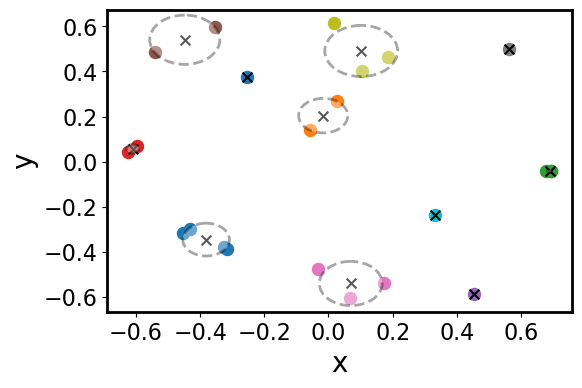

In [7]:
if (visualization == True):
    covariances = cluster2d.covariances_
    xmlad_plt.plot_cluster2d(projected_samples, clusters, centroids, covariances, cov_type)
    if (save_figures == True):
        plt.savefig('images/nokia_dataset/LP_clustering2D.png', 
                    format = 'png',
                    bbox_inches='tight', 
                    pad_inches=0)
    plt.show()

### KPI discretization

In [8]:
y_train = data_non_outliers[target_kpi].values.reshape(-1, 1)
n_bins  = int(np.log2(len(y_train))/2)

discretization_model = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans').fit(y_train)
yd = discretization_model.transform(y_train)[:,0]
val, count = np.unique(yd, return_counts=True)
labels = ['Very good', 'Good', 'Fair', 'Bad', 'Very bad']

#### Visualization discretization (optional)

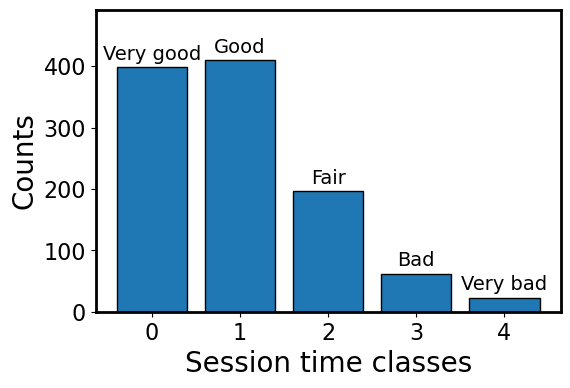

In [9]:
if (visualization == True):
    xmlad_plt.hist_discretization(val, count, labels)
    if (save_figures == True):
        plt.savefig('images/nokia_dataset/LP_discretization.png', 
                    format='png',
                    bbox_inches='tight', 
                    pad_inches=0)
    plt.show()

## Training of the anomaly detection engine

In [10]:
X_train  = data_non_outliers[train_cols].copy()
vl, cnts = np.unique(yd, return_counts=True)
knowledge, scores, ccp_alphas, best_alpha = xmlad_mod.build_decision_tree(n_bins, 5, X_train, yd, np.min(cnts))

#### Decision tree optimization (optional)

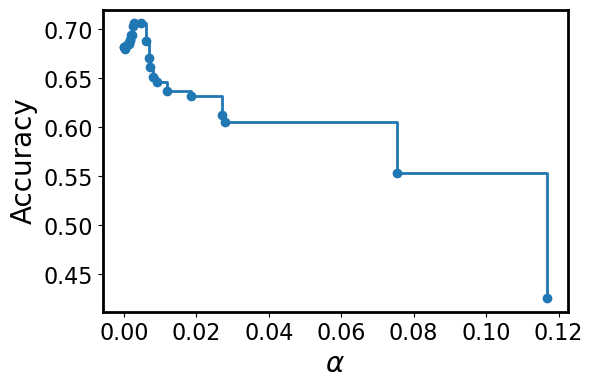

In [11]:
if (visualization == True):
    xmlad_plt.plot_pruning(ccp_alphas, scores)
    if (save_figures == True):
        plt.savefig('images/nokia_dataset/LP_model1_optimization.png', 
                    format = 'png',
                    bbox_inches='tight', 
                    pad_inches=0)
    plt.show()

### Display decision tree structure

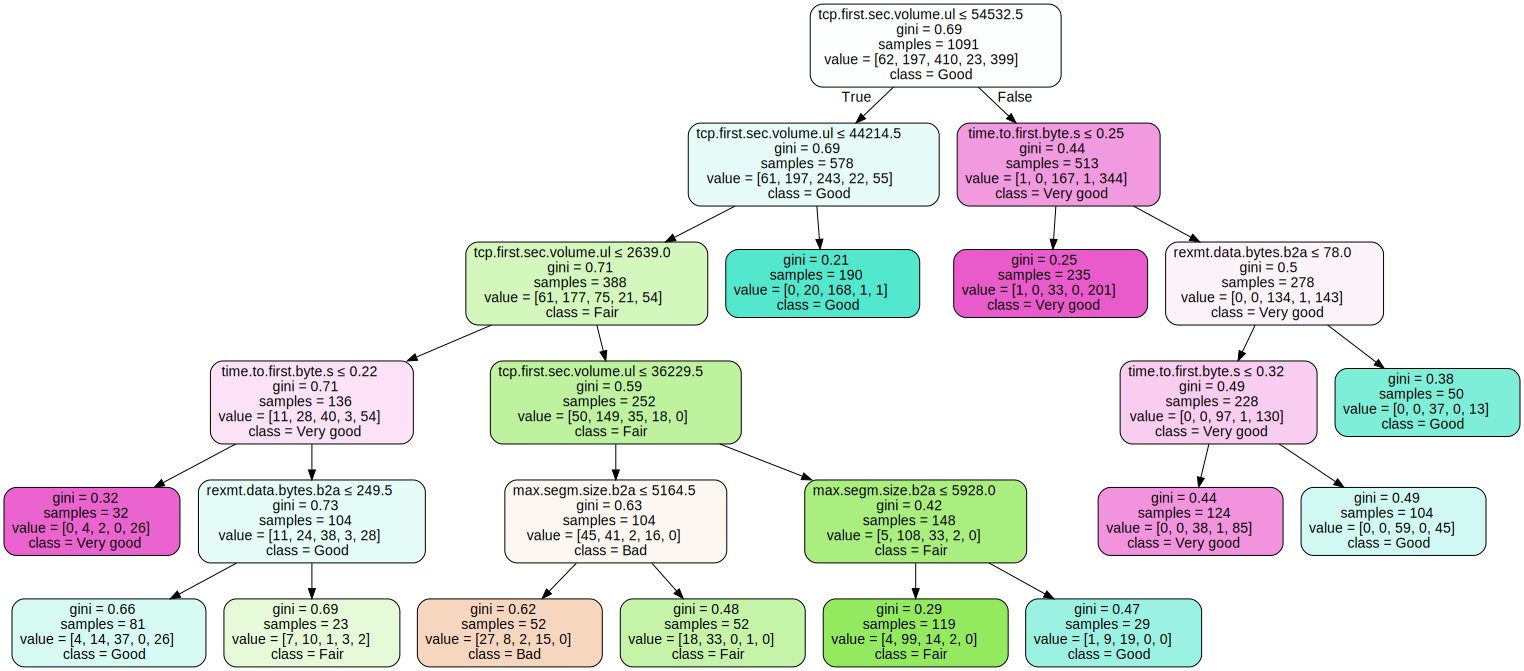

In [12]:
bins = discretization_model.bin_edges_[0].tolist()
data1= pd.cut(x=y_train.reshape(-1), bins = bins, labels=labels[0:val.shape[0]], include_lowest=True)
knowledge_label = DecisionTreeClassifier(max_depth=n_bins, min_samples_leaf=5, ccp_alpha=best_alpha)
knowledge_label.fit(X_train, data1)

dot_data = tree.export_graphviz(knowledge_label, 
                                feature_names = np.array(X_train.columns), 
                                class_names=knowledge_label.classes_, 
                                filled=True, 
                                rounded=True, 
                                out_file=None,
                                precision=2,
                                special_characters=True)

graph = graphviz.Source(dot_data)
graph.format='png'
#graph.format='svg'
filename = graph.render(filename='models/nokia_dataset/model1_livepage_dl')
graph

## Feature Selection based on the miscoding metric

### Vector of anomalous scenarios

In [13]:
y      = data[target_kpi].values.reshape(-1, 1)
ydt    = discretization_model.transform(y)[:,0]
y_pred = knowledge.predict(data[train_cols])
y_diff = y_pred - ydt
y_diff[y_diff > 0] = 0
data["Diff_Pred"] = y_diff
val, count = np.unique(y_diff, return_counts=True)

#### Ploting the histogram of the differences (optional)

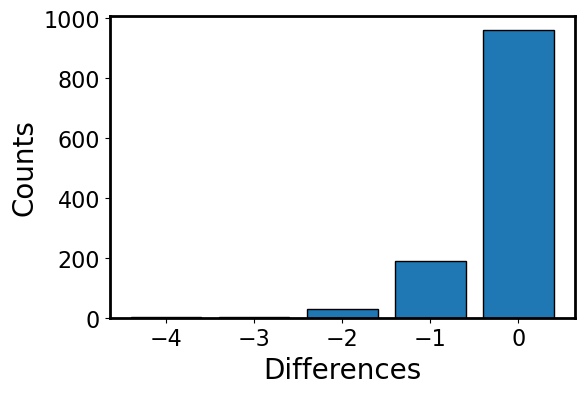

In [14]:
if (visualization == True):
    xmlad_plt.hist_differences(val, count)
    if (save_figures == True):
        plt.savefig('images/nokia_dataset/LP_differences.png', 
                    format = 'svg',
                    bbox_inches='tight', 
                    pad_inches=0)
    plt.show()

### Miscoding

In [15]:
data_misc    = data.drop(columns =[target_kpi, "Diff_Pred"])
column_names = np.array(data_misc.columns)
n_clusters   = int(np.log2(len(data.index))/2)
n_features   = min(n_clusters * n_clusters, len(data_misc.columns))
miscoding    = Miscoding(redundancy=True).fit(data_misc, data["Diff_Pred"])
mscd         = miscoding.miscoding_features()
best_mscd    = np.argsort(-mscd)[0:n_features]
attributes   = column_names[best_mscd]
print(attributes)

['rexmt.data.pkts.b2a' 'time.to.first.byte.s' 'rexmt.data.bytes.b2a'
 'sack.pkts.sent.a2b' 'ack.pkts.sent.a2b' 'segs.cum.acked.a2b'
 'dsack.pkts.sent.a2b' 'rtt.from.3whs.a2b' 'tcp.first.sec.volume.ul'
 'min.win.adv.a2b' 'max.sack.blks.ack.a2b' 'tcp.first.sec.volume.dl'
 'max.segm.size.b2a' 'avg.win.adv.a2b' 'truncated.packets.b2a'
 'adv.wind.scale.a2b' 'max.win.adv.a2b' 'truncated.data.b2a'
 'end.rssi.dbm' 'start.rssi.dbm' 'min.segm.size.b2a'
 'service.access.rssi.start.dbm']


#### Barplot of miscoding values

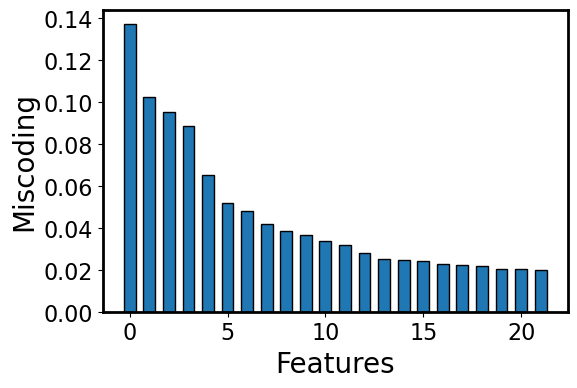

In [16]:
if (visualization == True):
    xmlad_plt.barplot_miscoding(mscd, n_features)
    if (save_figures == True):
        plt.savefig('images/nokia_dataset/LP_miscoding.png', 
                    format = 'png',
                    bbox_inches='tight', 
                    pad_inches=0)
    plt.show()

## Identification of problematic attributes and experiments

In [17]:
all_ratios = np.array([])
for i in range(len(attributes)):
    attr = data[attributes[i]]
    scaler = StandardScaler()
    scaler.fit(attr.values.reshape(-1, 1))
    data2prc = scaler.transform(attr.values.reshape(-1, 1))
    clustering, centroidsxx, covariances, _ = xmlad_mod.model_based_clustering(data2prc, 5, 1234, 'spherical')
    classes = np.unique(clustering)
    
    if (classes.shape[0] > 1):
        ratio = np.zeros(classes.shape[0])
        for ii in range(classes.shape[0]):
            ratio[ii] = y_diff[clustering==classes[ii]].mean()
        all_ratios = np.append(all_ratios, ratio)
all_ratios = all_ratios[np.argsort(-all_ratios)]
num_prob_att = np.ceil(np.log2(np.log2(len(y_diff))/2)).astype(int)

/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

In [18]:
k = 0
kk = 0
while (k != num_prob_att):
    models = pd.DataFrame({"Attribute":pd.Series(dtype='str'),
                          "best_model":pd.Series(dtype='str'),
                          "Class_1":pd.Series(dtype='float'),
                          "Class_2":pd.Series(dtype='float')})
    threshold = all_ratios[kk]
    print('Threshold: %.2f'%(threshold))
    k=0
    kk += 1
    for i in range(len(attributes)):
        attr = data[attributes[i]]
        scaler = StandardScaler()
        scaler.fit(attr.values.reshape(-1, 1))
        data2prc = scaler.transform(attr.values.reshape(-1, 1))
        clustering, _, _, _= xmlad_mod.model_based_clustering(data2prc, 5, 1234, 'spherical')
        classes = np.unique(clustering) 
        class_problem = np.zeros(clustering.shape)
   
        if (classes.shape[0] > 1):
            for ii in range(classes.shape[0]):
                ratio = y_diff[clustering==classes[ii]].mean()
                if ((ratio <= threshold) & (clustering[clustering==classes[ii]].shape[0] > 0.1*clustering.shape[0])):
                    class_problem[clustering==classes[ii]]=1
                else:
                    class_problem[clustering==classes[ii]]=2
            problem_classes = np.unique(class_problem)
            if (problem_classes.shape[0] > 1):
                if (k==0):
                    cls_mat = class_problem.reshape(-1,1)
                else:
                    cls_mat= np.hstack((cls_mat, class_problem.reshape(-1,1)))
                k=k+1            
                counts = np.array([class_problem[class_problem==1].shape[0], class_problem[class_problem==2].shape[0]])
                total  = np.sum(counts)
                models = models.append({'Attribute':attributes[i],
                                          'best_model':'best_model',
                                          'Class_1':counts[0]/total,
                                          'Class_2':counts[1]/total},ignore_index=True)
print(models)

Threshold: 0.00


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: 0.00


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: 0.00


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: 0.00


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.15


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.16


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.16


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.17


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.17


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.17


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.18


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.18


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.18


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.18


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.18


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.18


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.19


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.19


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.19


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.19


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.19


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.19


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.20


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.20


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.20


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.20


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.20


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.21


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.21


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.21


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.21


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.21


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.21


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.21


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.21


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.21


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.22


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.22


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.23


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.23


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.23


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.24


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.24


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.26


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.26


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.26


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.26


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.27


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.28


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.28


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.28


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.29


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.29


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.29


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

Threshold: -0.30


/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/home/juan/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicat

                 Attribute  best_model   Class_1   Class_2
0     time.to.first.byte.s  best_model  0.101266  0.898734
1        rtt.from.3whs.a2b  best_model  0.117300  0.882700
2  tcp.first.sec.volume.ul  best_model  0.125738  0.874262


In [19]:
attributes = models["Attribute"].values
attributes, att_ind = np.unique(attributes, return_index=True)
cls_mat = cls_mat[:,att_ind]

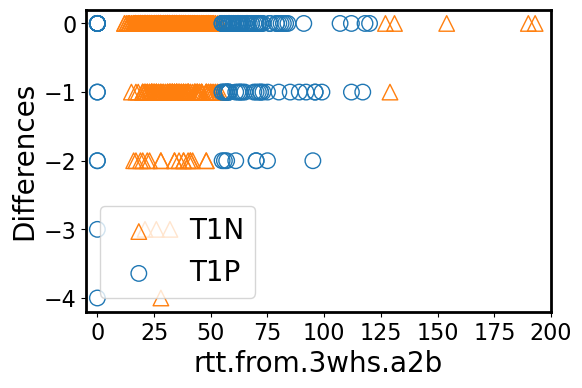

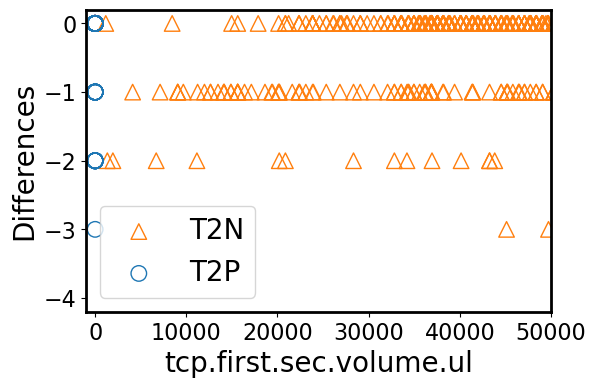

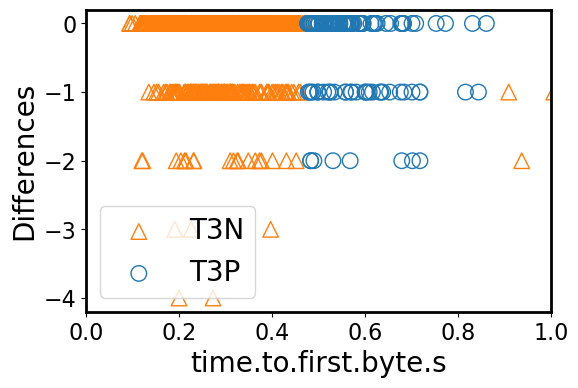

In [20]:
if (visualization == True):
    k = 0;
    for attr in attributes:
        cls_vec = cls_mat[:,k]
        bl_vec1 = (cls_vec==1)
        bl_vec2 = (cls_vec==2)
    
        fig = plt.figure(dpi=100) #Paper figure
        ax = fig.add_subplot()
        plt.scatter(data[attr][bl_vec2], data["Diff_Pred"][bl_vec2], label='T%dN'%(k+1), marker='^',color='tab:orange',s=125, facecolors='none')
        plt.scatter(data[attr][bl_vec1], data["Diff_Pred"][bl_vec1], label='T%dP'%(k+1), marker='o',color='tab:blue',s=125, facecolors='none')
        plt.legend(fontsize=20, loc='lower left' )

        if (k==0):
            plt.xlim((-5,200))
        if (k==2):
            plt.xlim((0,1))
        if (k==1):
            plt.xlim((-1000,50000))
        plt.xlabel(attr.replace('_','\_'), fontsize=20)
        plt.ylabel("Differences", fontsize=20)
        plt.yticks([-4, -3,-2, -1, 0], fontsize=16)
        plt.xticks(fontsize=16)
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(2.0)  # change width
        k = k+1
        if (save_figures == True):  
            plt.savefig('images/nokia_dataset/LP_problematic_features_%02d.png'%(k),
                        format = 'png',
                        bbox_inches='tight', 
                        pad_inches=0)
        plt.show()    

## Generation of anomaly classification labels 

In [21]:
problem = np.empty(cls_mat.shape[0], dtype=object)
separator = ';'
for ii in range(cls_mat.shape[0]):    
    strings = []
    for jj in range(cls_mat.shape[1]):
        if (cls_mat[ii,jj] == 1):
            strings = strings + ['T%dP'%(jj+1)]
        if (cls_mat[ii,jj] == 2):
            strings = strings + ['T%dN'%(jj+1)]
    problem[ii] = separator.join(strings)    

## Building the anomaly classification engine

In [22]:
X            = data.copy()
X['Problem'] = problem
X.loc[X.Problem.str.contains('^[^P]+$'), "Problem"] = "Compliant"    
fX           = X.copy()
fy           = fX["Problem"]
fX           = fX.drop(["Problem", "Diff_Pred", target_kpi], axis=1)
depth = np.ceil(np.log2(np.sum(fy != "Compliant"))/2)

classifier, scores, ccp_alphas, best_alpha = xmlad_mod.build_decision_tree(depth, 5, fX, fy, None)

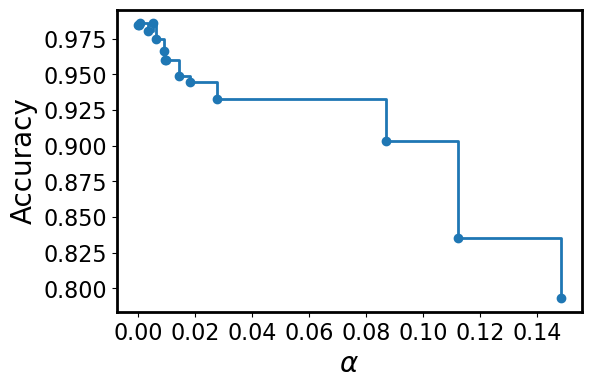

In [23]:
if (visualization == True):
    xmlad_plt.plot_pruning(ccp_alphas, scores)
    if (save_figures == True):  
        plt.savefig('images/nokia_dataset/LP_model2_optimization.png', 
                    format = 'png',
                    bbox_inches='tight', 
                    pad_inches=0)
    plt.show()

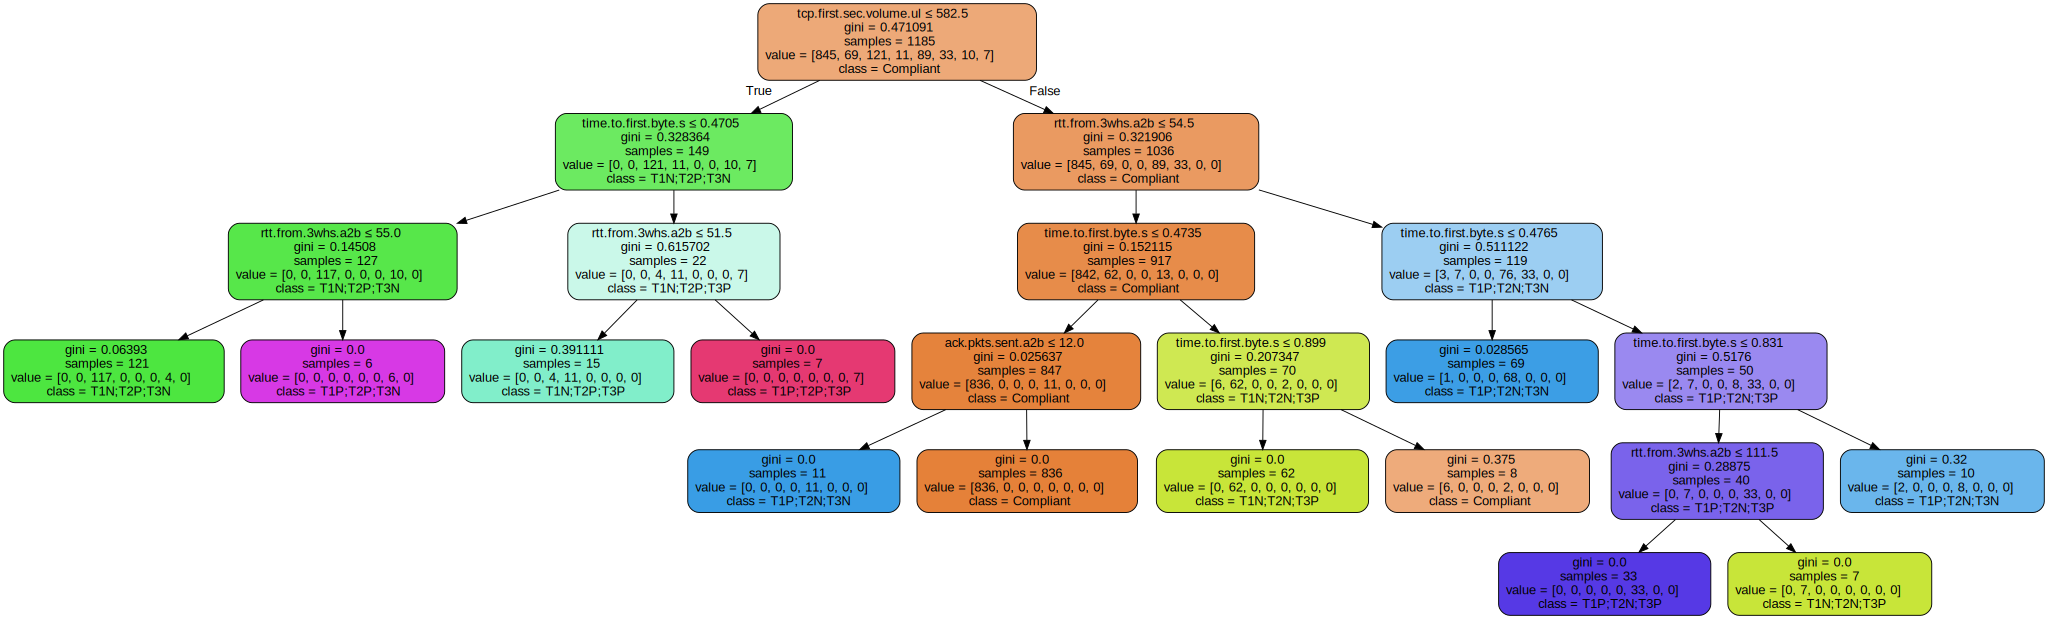

In [24]:
dot_data = tree.export_graphviz(classifier, 
                                feature_names = np.array(fX.columns), 
                                class_names=classifier.classes_, 
                                filled=True, 
                                rounded=True, 
                                out_file=None,
                                precision=6,
                                special_characters=True)

graph = graphviz.Source(dot_data)
#graph.format='svg'
graph.format='png'
filename = graph.render(filename='models/nokia_dataset/model2_livepage_dl')
graph